# Task

Today we will see a code implemented using Numpy for distinguishing between the digit 8 and the digit 3 from the MNIST dataset (http://yann.lecun.com/exdb/mnist/) using logistic regression. This recitation will be a showcase for the standard deep learning pipeline. We will also see some useful tricks that make NN work better and converge faster.

# Read Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # for plotting
# import torch
# import torchvision
import torchvision.datasets as datasets
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"



np.random.seed(42)  # fixing seed. Important for reproducibility!

In [2]:
def plot_image(X, title, ax):
    ax.imshow(X, cmap='gray')
    ax.axis('off') # hide the axes ticks
    ax.set_title(title, color= 'black', fontsize=25)

In [3]:
# read train and test files
train_data = mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_data = mnist_trainset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


In [4]:
#let's see the first few rows
print("train data shape: ", train_data.data.shape, " test data shape: ", test_data.data.shape, "\n")

train data shape:  torch.Size([60000, 28, 28])  test data shape:  torch.Size([10000, 28, 28]) 



In [5]:
# separate labels from data for convenience
y = train_data.targets.numpy()
X = train_data.data.numpy()

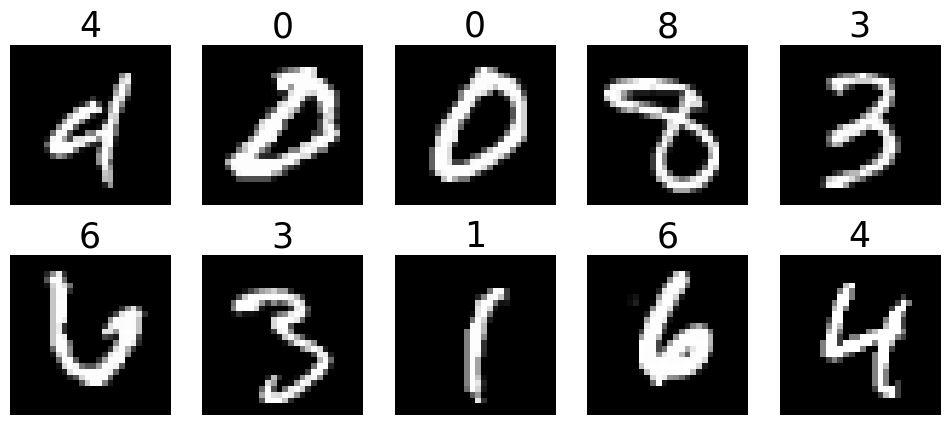

In [6]:

# create plot template
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()

# pick random 10 images and plot them
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    img = X[idx[i],:].reshape(28,28)  # image
    title = str(int(y[idx[i]]))  # class label
    plot_image(img, title, axes[i])
plt.show()

# note that min values are 0 (black pixel), max values are 255 (white pixel), values in between are greys

# Data Processing

## Take images of '3' and '8'

In [7]:
y = train_data.targets.numpy()
X = train_data.data.numpy()
y_test = test_data.targets.numpy()
X_test = test_data.data.numpy()

In [8]:
train_data.targets.numpy().shape

(60000,)

In [9]:
type(train_data.targets.numpy)

builtin_function_or_method

In [10]:
# first, let's filter only those samples with '8' and '3' from both training and test
# take only these digits
digits = [3, 8]
trn38 = X[np.where(np.isin(y, digits))[0]]
X_test = X_test[np.where(np.isin(y_test, digits))[0]]

y = y[np.where(np.isin(y, digits))[0]]
y_test = y_test[np.where(np.isin(y_test, digits))[0]]


In [11]:
# add constant "1" for the bias term
N_train = trn38.shape[0]  # number of training samples
trn38 = np.concatenate((np.ones((N_train, 1)), trn38.reshape(N_train, -1)), axis=1)
N_test = X_test.shape[0]  # number of test samples
X_test = np.concatenate((np.ones((N_test, 1)), X_test.reshape(N_test, -1)), axis=1)

In [12]:

# rename the class 3 as "0" and the class 8 as "1"
y[y == digits[0]] = 0
y[y == digits[1]] = 1
y_test[y_test == digits[0]] = 0
y_test[y_test == digits[1]] = 1

print("train data shape: ", trn38.shape, " test data shape: ", X_test.shape, "\n")

train data shape:  (11982, 785)  test data shape:  (1984, 785) 



## Split the train set to train-val

To compare between models or optimize hyperparameters (e.g., batch-size, regularization term and coefficient, learning rate) we need a validation set. When we have enough data one split is enough.

Note that it is important to maintain the same distribution in both train and validation sets. To do so we will use stratified sampling.

In [13]:
from sklearn.model_selection import train_test_split  # I will use sklearn train test split function. Very useful!

val_pct = 0.2  # set percentage for validation split
random_state = 42  # random seed for reproducibility
# all the magic happans inside. Shuffle data, very important!
X_train, X_val, y_train, y_val = train_test_split(trn38, y, test_size=val_pct, 
                                                  random_state=random_state, stratify=y, shuffle=True)

print("train data shape: ", X_train.shape, " validation data shape: ", X_val.shape, "\n")

train data shape:  (9585, 785)  validation data shape:  (2397, 785) 



## Normalizing the input

Convergence is usually faster if:
- Inputs are centered around zero
- Inputs are scaled such that each feature (pixle) has about the same variance
- Inputs are uncorrelated

The first two are relatively easy to obtain. The third one is trickier and we will not discuss it.
Popular normalization techniques (based on the training data only):
- Min-Max normalization: $\hat{x}_i= \frac{x_i-min_j(x_i)}{max_j(x_i)-min_j(x_i)}$, where $x_i$ is the i-th feature, and $j$ is an index running over all instances of the i-th feature in the training set.


- Z-score normalization: $\hat{x}_i= \frac{x_i-\mu(x_i)}{\sigma(x_i)}$, where $\mu(x_i)$ and $\sigma(x_i)$ are the mean and std of the i-th feature calculated on the training set.

In [14]:
def normalize(X):
    # get min and max per feature (except the first one which corresponds to the bias term)
    X_min = np.min(X[:, 1:], axis=0)
    X_max = np.max(X[:, 1:], axis=0)
    return (X[:, 1:] - X_min)/(X_max - X_min + eps)

# here we will do the min-max normalization (since it is easier in this case :-)).
eps = 1e-8  # add small epsilon for numerical stability
X_train[:, 1:] = normalize(X_train)
X_val[:, 1:] = normalize(X_val)
X_test[:, 1:] = normalize(X_test)

# Binay Logistic Regression Classifier

1. **Training data:** $(\mathrm{x_1}, y_1), ...,(\mathrm{x_{n}}, y_{n})$ where, $\mathrm{x_j} \in \mathbb{R}^{784}$ and $y_j \in \{0, 1\}$


2. **Sigmoid activation:**

    \begin{align}
    \sigma(z) &= \frac{1}{1 + e^{-z}}\\
    p(y_j=1 | \mathrm{x_j}; \mathrm{w}) &= \sigma(\mathrm{w}^T\mathrm{x_j})\\
    p(y_j=0 | \mathrm{x_j}; \mathrm{w}) &= 1 - \sigma(\mathrm{w}^T\mathrm{x_j})
    \end{align}

3. **Log-likelihood:** 
    
    \begin{align}
    L((X,Y);\mathrm{w}) &= -\frac{1}{n}\sum_{j=1}^{j=n} log~p(y_j | \mathrm{x_j}; \mathrm{w})\\
    &= -\frac{1}{n}\sum_{j=1}^{j=n} log~[p(y_j = 1| \mathrm{x_j}; \mathrm{w})^{y_j} \cdot (1 - p(y_j = 1| \mathrm{x_j}; \mathrm{w}))^{1 - y_j}]\\
     &= -\frac{1}{n} \sum_{j=1}^{j=n} y_j \cdot \log~p(y_j = 1 | \mathrm{x_j}; \mathrm{w}) + (1 - y_j) \cdot \log~p(y_j=0 | \mathrm{x_j}; \mathrm{w})\\
     &= -\frac{1}{n} \sum_{j=1}^{j=n} y_j \cdot \log~\sigma(\mathrm{w}^T\mathrm{x_j}) + (1 - y_j) \cdot \log~(1 - \sigma(\mathrm{w}^T\mathrm{x_j}))
    \end{align}

4. **Optimization problem:**

    \begin{align}
    \hat{\mathrm{w}} &= arg\,min_{\mathrm{w}}L((X,Y);\mathrm{w})
    \end{align}
5. **Gradient of the loss function:**

    To minimize the loss function $ L((X, Y); \mathrm{w}) $, we need its gradient with respect to $ \mathrm{w} $. The derivative is given by:

    \begin{align}
    \nabla_{\mathrm{w}} L &= -\frac{1}{n} \sum_{j=1}^{n} (y_j - p(y_j=1 | \mathrm{x}_j; \mathrm{w})) \mathrm{x}_j,
    \end{align}

    where  $ p(y_j=1 | \mathrm{x}_j; \mathrm{w}) = \sigma(\mathrm{w}^T \mathrm{x}_j) $

    To derive this, we start by differentiating the log-likelihood $ L((X, Y); \mathrm{w}) $ with respect to $ \mathrm{w} $. The derivative of the term $ y_j \log(\sigma(\mathrm{w}^T \mathrm{x}_j)) + (1 - y_j) \log(1 - \sigma(\mathrm{w}^T \mathrm{x}_j)) $ simplifies to $ (y_j - \sigma(\mathrm{w}^T \mathrm{x}_j)) \mathrm{x}_j $, resulting in the expression shown above after summing over all data points.

    **Gradient descent update rule:**

    To update $ \mathrm{w} $ iteratively, we use:

    \begin{align}
    \mathrm{w}^{t+1} &= \mathrm{w}^t - \eta \nabla_{\mathrm{w}} L(\mathrm{w}^t),
    \end{align}

    or equivalently:

    \begin{align}
    \mathrm{w}^{t+1} &= \mathrm{w}^t + \eta \frac{1}{n} \sum_{j=1}^{n} (y_j - p(y_j=1 | \mathrm{x}_j; \mathrm{w}^t)) \mathrm{x}_j.
    \end{align}

    **Explanation of terms:**
    - $ \eta $ is the learning rate that determines the step size for updates.
    - $ \mathrm{w}^{t} $ is the parameter vector at iteration $ t $.



<!-- 5. **Gradient descent update rule:**

    To minimize the loss function $\mathbf{L((X,Y);\mathrm{w})}$, we use gradient descent. The gradient of $ \mathbf{L}$ with respect to $\mathbf{\mathrm{w}}$ is:

    \begin{align}
    \nabla_{\mathbf{\mathrm{w}}} \mathbf{L} &= - \frac{1}{n} \sum_{j=1}^{n} ( \mathbf{y}_j - p(\mathbf{y}_j=1 | \mathbf{\mathrm{x}}_j; \mathbf{\mathrm{w}})) \mathbf{\mathrm{x}}_j,
    \end{align}

    where $p(\mathbf{y}_j=1 | \mathbf{\mathrm{x}}_j; \mathbf{\mathrm{w}}) = \sigma(\mathbf{\mathrm{w}}^T \mathbf{\mathrm{x}}_j)$.

    **Update step:**
    $$
    \mathbf{w}^{t+1} = \mathbf{w}^t - \eta \nabla_{\mathbf{w}} \mathbf{L}(\mathbf{w}^t),
    $$
    or equivalently:
    $$
    \mathbf{w}^{t+1} = \mathbf{w}^t + \eta \frac{1}{n} \sum_{j=1}^{n} (\mathbf{y}_j - p(\mathbf{y}_j=1 | \mathbf{x}_j; \mathbf{w}^t)) \mathbf{x}_j.
    $$


    Here, $\eta$ is the learning rate controlling the update step size. -->


## Sigmoid activation

In [15]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

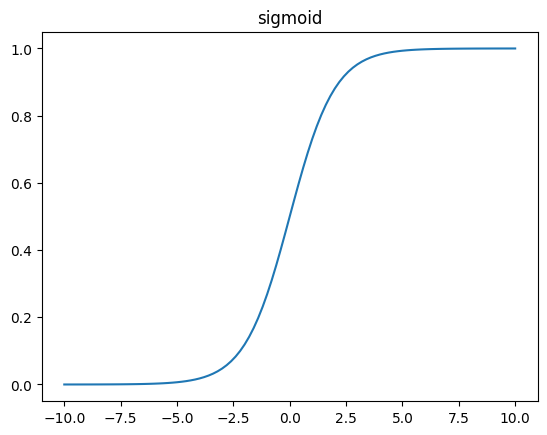

In [16]:
z = np.linspace(-10, 10, 101)  # generate 101 points evenly spaced samples on the interval [-10, 10]
s = sigmoid(z)  # apply sigmoid
plt.plot(z, s)
plt.title('sigmoid');

## CE Loss function

In [17]:
def cross_entropy(y_true, y_pred):
    '''
    Implementation of the cross entropy loss function
    y_true: ground truth, of shape (M, )
    z: Wx (M, ) 
    M: number of samples in the batch
    Return: scalar
    '''
    eps = 0.0000001
    p_y_given_x = - (y_true * np.log(y_pred + eps) + (1 - y_true) * np.log((1 - y_pred) + eps))
    CE_loss = np.mean(p_y_given_x)
    return CE_loss

## Derivatives

In [18]:
def dL_dW(y_true, y_pred, X):
    # average over rows
    M = X.shape[0]
    return - (1 / M) * X.transpose() @ (y_true - y_pred)

## Forward pass

In [19]:
def test(X, y, W):
    N_test = X.shape[0]  # number of training samples
        
    # matrix-vector multiplication
    z = X @ W

    # calc. probaility of y_j = 1 for each input (M,)
    sig_z = sigmoid(z).reshape(-1)

    # calculate loss
    test_loss = cross_entropy(y, sig_z)

    # calc. accuracy
    labels = y.reshape(-1)
    preds = np.where(sig_z < 0.5, np.zeros_like(sig_z), np.ones_like(sig_z))
    accuracy = np.mean(np.equal(labels, preds))
    return accuracy, test_loss

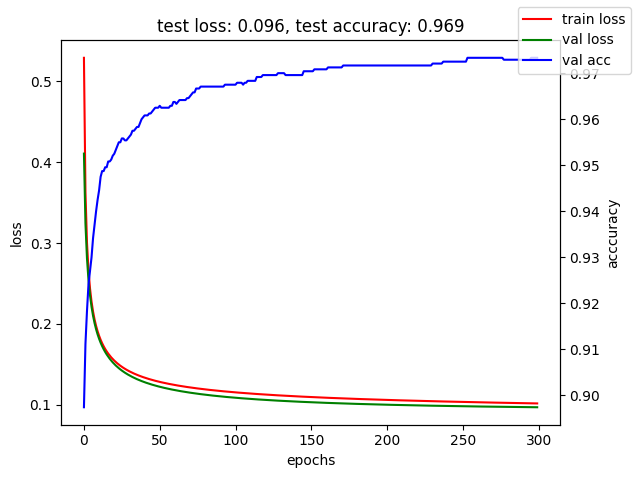

In [20]:
M = 128  # batch size
eta = 0.01 # learning rate
epochs = 300  # number of times to iterate over the entier dataset
N = X_train.shape[0]  # number of training samples
d = X_train.shape[1]  # dimension = 784 + 1 (for the bias term)

W = np.random.normal(loc=0.0, scale=0.01, size=(d, 1))  # initalize weights iid from a gaussian with small noise
train_losses, val_losses, val_accuracy = ([] for i in range(3))

# iterations over entire dataset
for epoch in range(epochs):
    loss = 0
       
    # batch iterations whithin each dataset iteration 
    for batch_idx, idx_start in enumerate(range(0, N, M)):
        idx_end = min(idx_start + M, N)
        X_batch = X_train[idx_start:idx_end, :]  # take all data in the current batch
        y_batch = y_train[idx_start:idx_end].reshape(-1, 1)  # take relevant labels
        
        # matrix-vector multiplication
        z = X_batch @ W
        
        # calc. probaility of y_j = 1 for each input (M,)
        sig_z = sigmoid(z)
        
        # calculate loss
        batch_loss = cross_entropy(y_batch, sig_z)
        loss += batch_loss
        
        # compute gradient of the loss w.r.t W
        delta_W = dL_dW(y_batch, sig_z, X_batch)
        
        # update W
        W = W - eta * delta_W
        
    ##### validation ####
    val_acc, val_loss = test(X_val, y_val, W)
    
    # save for plotting
    train_losses.append(loss / batch_idx)
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

# check performance on test set
test_acc, test_loss = test(X_test.reshape(X_test.shape[0], -1), y_test, W)

# plot loss and accuracy on validation set
steps = np.arange(epochs)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('test loss: %.3f, test accuracy: %.3f' % (test_loss, test_acc))
ax1.plot(steps, train_losses, label="train loss", color='red')
ax1.plot(steps, val_losses, label="val loss", color='green')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('acccuracy')  # we already handled the x-label with ax1
ax2.plot(steps, val_accuracy, label="val acc", color='blue')

fig.legend()
fig.tight_layout()
plt.show()

# Analysis

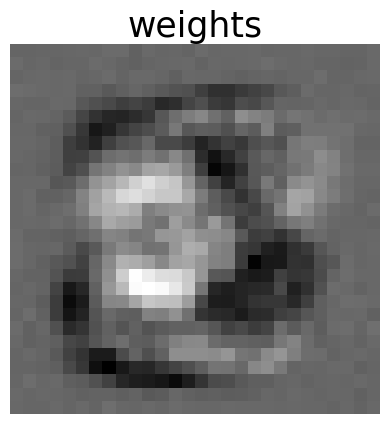

In [21]:
# create plot template
ax = plt.subplot(111)
title = 'weights'
W_wo_bias = W[1:, 0]  # remove bias
tmp = (W_wo_bias - np.min(W_wo_bias)) / (np.max(W_wo_bias) - np.min(W_wo_bias))  # scale to 0-1
plot_image(tmp.reshape(28,28), title, ax)
plt.show()